# NGram Language Models

```yaml
Course:  DS 5001
Module:  03 Lab
Topic:   NGram Language Models
Author:  R.C. Alvarado
Date:    12 December 2023
```

## Purpose 

We now create a series of simple n-gram langage models from our small corpus and evaluate them.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by averaging sentence information sums and exponentiating. 

## Set Up

### Import libraries

In [1]:
import pandas as pd
import numpy as np

### Configure

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [3]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
path_prefix = f"{output_dir}/austen-combo"
n = 3

## Get Data

We grab our corpus of two novels.

In [4]:
VOCAB = pd.read_csv(f"{path_prefix}-VOCAB.csv").set_index('term_str')
TOKEN = pd.read_csv(f"{path_prefix}-TOKENS.csv").set_index(OHCO)

## Generate Models

This function generates models up to the length specified.

Our approach is to bind the sequence of term strings in TOKEN to itself with an offset of 1 for each value of $n$.

In [5]:
TOKEN

token_str     term_str
book_id chap_num para_num sent_num token_num                          
1       1        0        0        0                  Sir          sir
                                   1               Walter       walter
                                   2               Elliot       elliot
                                   3                   of           of
                                   4             Kellynch     kellynch
...                                                   ...          ...
2       50       22       0        8                  and          and
                                   9          Sensibility  sensibility
                                   10                  by           by
                                   11                Jane         jane
                                   12              Austen       austen

[204802 rows x 2 columns]

### `get_ngrams()`

In [46]:
def get_ngrams(TOKEN, n=2, sent_key='sent_num'):
    
    OHCO = TOKEN.index.names
    grouper = list(OHCO)[:OHCO.index(sent_key)+1]

    PADDED = TOKEN.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x.term_str) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    PADDED.index.names = grouper + ['token_num']

    NGRAMS = PADDED.groupby(grouper)\
        .apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1)).reset_index(drop=True)
    NGRAMS.index = PADDED.index
    NGRAMS.columns = [f'w{j}' for j in range(n)]
    
    return NGRAMS

In [47]:
NG = get_ngrams(TOKEN, n=3)

In [49]:
NG.loc[(1,1,0,0)]

,w0,w1,w2
token_num,,,
0,<s>,sir,walter
1,sir,walter,elliot
2,walter,elliot,of
3,elliot,of,kellynch
4,of,kellynch,hall
5,kellynch,hall,in
6,hall,in,somersetshire
7,in,somersetshire,was
8,somersetshire,was,a


In [48]:
NG.iloc[:,:3]

w0        w1        w2
book_id chap_num para_num sent_num token_num                                 
1       1        0        0        0                  <s>       sir    walter
                                   1                  sir    walter    elliot
                                   2               walter    elliot        of
                                   3               elliot        of  kellynch
                                   4                   of  kellynch      hall
...                                                   ...       ...       ...
2       50       22       0        10         sensibility        by      jane
                                   11                  by      jane    austen
                                   12                jane    austen      </s>
                                   13              austen      </s>      None
                                   14                </s>      None      None

[230426 rows x 3 columns]

### `get_ngram_counts()`

In [9]:
def get_ngram_counts(NGRAM):
    "Compress the sequences into counts"
    
    n = len(NGRAM.columns)
    C = [None for i in range(n)]
    
    for i in range(n):

        # Count distinct ngrams
        C[i] = NGRAM.iloc[:, :i+1].value_counts().to_frame('n').sort_index()
    
        # Get joint probabilities (MLE)
        C[i]['p'] = C[i].n / C[i].n.sum()
        C[i]['i'] = np.log2(1/C[i].p)

        # Get conditional probabilities (MLE)
        if i > 0:
            C[i]['cp'] = C[i].n / C[i-1].n
            C[i]['ci'] = np.log2(1/C[i].cp)
            
    
    # Convert index vales to scalars from single tuples        
    C[0].index = [i[0] for i in C[0].index]
    C[0].index.name = 'w0'
            
    return C

Generate unigram, bigram, and trigram models.

In [10]:
M = get_ngram_counts(NG)

In [11]:
M[0].sort_values('n')

,n,p,i
w0,,,
journeys,1,0.000004,17.813944
edify,1,0.000004,17.813944
ponder,1,0.000004,17.813944
politics,1,0.000004,17.813944
politicians,1,0.000004,17.813944
...,...,...,...
and,6290,0.027297,5.195100
to,6923,0.030044,5.056762
the,7435,0.032266,4.953827


In [12]:
M[1].sort_values('n')

n         p          i        cp        ci
w0    w1                                                      
1     1760          1  0.000004  17.813944  0.333333  1.584963
often keeps         1  0.000004  17.813944  0.012195  6.357552
      led           1  0.000004  17.813944  0.012195  6.357552
      makes         1  0.000004  17.813944  0.012195  6.357552
      observed      1  0.000004  17.813944  0.012195  6.357552
...               ...       ...        ...       ...       ...
of    the         857  0.003719   8.070793  0.139440  2.842281
<s>   but         929  0.004032   7.954409  0.072510  3.785673
      i          1000  0.004340   7.848160  0.078052  3.679424
      and        1417  0.006149   7.345320  0.110599  3.176584
</s>  <s>       12812  0.055601   4.168736  1.000000  0.000000

[78626 rows x 5 columns]

In [13]:
M[1].sample(5)

,,n,p,i,cp,ci
w0,w1,,,,,
openness,their,1,0.000004,17.813944,0.111111,3.169925
theirs,and,1,0.000004,17.813944,0.100000,3.321928
rapid,recovery,1,0.000004,17.813944,0.111111,3.169925
assurance,of,5,0.000022,15.492016,0.357143,1.485427
read,nothing,1,0.000004,17.813944,0.028571,5.129283


In [14]:
M[2].sample(5)

,,,n,p,i,cp,ci
w0,w1,w2,,,,,
might,pass,for,1,0.000004,17.813944,1.000000,0.000000
very,strong,resemblance,1,0.000004,17.813944,0.250000,2.000000
a,pressing,invitation,1,0.000004,17.813944,1.000000,0.000000
lucy,who,believed,1,0.000004,17.813944,0.083333,3.584963
connexions,</s>,<s>,1,0.000004,17.813944,1.000000,0.000000


In [15]:
M[2].loc[('captain','wentworth')].sort_values('n', ascending=False).head()

,n,p,i,cp,ci
w2,,,,,
s,26,0.000113,13.113504,0.132653,2.914270
</s>,24,0.000104,13.228981,0.122449,3.029747
was,15,0.000065,13.907053,0.076531,3.707819
in,8,0.000035,14.813944,0.040816,4.614710
had,7,0.000030,15.006589,0.035714,4.807355


In [16]:
M[2].loc[('anne','elliot')].sort_values('n', ascending=False).head()

,n,p,i,cp,ci
w2,,,,,
</s>,5,0.000022,15.492016,0.217391,2.201634
and,3,0.000013,16.228981,0.130435,2.938599
as,2,0.000009,16.813944,0.086957,3.523562
with,2,0.000009,16.813944,0.086957,3.523562
again,1,0.000004,17.813944,0.043478,4.523562


## Predict Sentences

### Get a list of test sentences

In [17]:
test_sentences = """
I love you
I love cars
I want to
Anne said to
said to her
he said to
she said to
said to him
she read the
she went to
robots fly ufos
""".split('\n')[1:-1]

### Convert list to TEST_SENT

In [18]:
TEST_SENT = pd.DataFrame({'sent_str':test_sentences})
TEST_SENT.index.name = 'sent_num'

In [19]:
TEST_SENT

,sent_str
sent_num,
0,I love you
1,I love cars
2,I want to
3,Anne said to
4,said to her
5,he said to
6,she said to
7,said to him
8,she read the


### Convert TEST_SENT to TEST_TOKEN

In [20]:
TEST_TOKEN = TEST_SENT.sent_str.str.split(expand=True).stack().to_frame('token_str')
TEST_TOKEN.index.names = ['sent_num', 'token_num']
TEST_TOKEN['term_str'] = TEST_TOKEN.token_str.str.replace(r'[\W_]+', '').str.lower()

In [21]:
TEST_TOKEN

token_str term_str
sent_num token_num                   
0        0                 I        i
         1              love     love
         2               you      you
1        0                 I        i
         1              love     love
         2              cars     cars
2        0                 I        i
         1              want     want
         2                to       to
3        0              Anne     anne
         1              said     said
         2                to       to
4        0              said     said
         1                to       to
         2               her      her
5        0                he       he
         1              said     said
         2                to       to
6        0               she      she
         1              said     said
         2                to       to
7        0              said     said
         1                to       to
         2               him      him
8        0               she      she
         1              read     read
         2               the      the
9        0               she      she
         1              went     went
         2                to       to
10       0            robots   robots
         1               fly      fly
         2              ufos     ufos

### Extract TEST_NGRAMS from TEST_TOKEN

In [22]:
TEST_NGRAMS = get_ngrams(TEST_TOKEN, n=3, sent_key='sent_num')

In [23]:
TEST_NGRAMS.head(10)

w0    w1    w2
sent_num token_num                  
0        0           <s>     i  love
         1             i  love   you
         2          love   you  </s>
         3           you  </s>   <s>
         4          </s>   <s>     i
1        0           <s>     i  love
         1             i  love  cars
         2          love  cars  </s>
         3          cars  </s>   <s>
         4          </s>   <s>     i

### Test the model

We test by joining the test ngrams with the model and then saving aggregate statistics to the sentence dataframe.

Note that testing is a special case of the split-apply-combine pattern.

### `test_model()`

In [24]:
def test_model(model, test_ngrams):

    # Get the model level and info feature
    n = len(model.index.names) - 1 
    f = 'c' * bool(n) + 'i'        

    # Do the test by join and then split-apply-combine
    # fillna() is used to hanlde OOV terms
    T = test_ngrams.join(model[f], on=model.index.names, how='left').fillna(model[f].max()) #.copy()
        
    R = T.groupby('sent_num')[f].agg(['sum','mean'])
    R['pp'] = np.exp2(R['mean'])
    
    return R

### Run tests and save as RESULT

In [25]:
RESULT = pd.concat(
    [test_model(M[i], TEST_NGRAMS.iloc[:,:i+1]) for i in range(len(M))],
    keys=[f"M{n}" for n in range(len(M))],
    axis=1
)

In [26]:
RESULT.style.background_gradient()

Show results for a given model.

In [27]:
pd.concat([TEST_SENT, RESULT['M0']], axis=1).sort_values('pp').style.background_gradient()

,sent_str,sum,mean,pp
sent_num,,,,
4,said to her,27.995784,5.599157,48.474589
6,she said to,28.437374,5.687475,51.534792
5,he said to,28.847713,5.769543,54.551337
7,said to him,29.752260,5.950452,61.839300
3,Anne said to,30.892889,6.178578,72.433134
2,I want to,31.201644,6.240329,75.600758
9,she went to,31.288412,6.257682,76.515617
8,she read the,32.359974,6.471995,88.769662
0,I love you,32.444531,6.488906,89.816355


In [28]:
pd.concat([TEST_SENT, RESULT['M1']], axis=1).sort_values('pp').style.background_gradient()

,sent_str,sum,mean,pp
sent_num,,,,
7,said to him,21.141560,4.228312,18.743415
4,said to her,21.158476,4.231695,18.787421
0,I love you,21.181306,4.236261,18.846977
9,she went to,21.641655,4.328331,20.088960
5,he said to,23.756214,4.751243,26.931877
6,she said to,23.994194,4.798839,27.835204
2,I want to,24.502196,4.900439,29.866147
3,Anne said to,27.709450,5.541890,46.588113
1,I love cars,39.580865,7.916173,241.549148


In [29]:
pd.concat([TEST_SENT, RESULT['M2']], axis=1).sort_values('pp').style.background_gradient()

,sent_str,sum,mean,pp
sent_num,,,,
7,said to him,22.871142,4.574228,23.822094
4,said to her,25.335105,5.067021,33.521644
0,I love you,26.875379,5.375076,41.501044
5,he said to,28.439985,5.687997,51.553444
6,she said to,31.749848,6.349970,81.570159
9,she went to,38.144617,7.628923,197.940544
3,Anne said to,42.131175,8.426235,343.992908
2,I want to,42.166699,8.433340,345.691132
1,I love cars,52.580832,10.516166,1464.473595


Compare a feature across models.

We use `.swaplevel()` to change the order of the column levels to make selection easy.

In [30]:
RESULT.swaplevel(axis=1).style.background_gradient()

,sum,mean,pp,sum,mean,pp,sum,mean,pp
,M0,M0,M0,M1,M1,M1,M2,M2,M2
sent_num,,,,,,,,,
0,32.444531,6.488906,89.816355,21.181306,4.236261,18.846977,26.875379,5.375076,41.501044
1,43.273461,8.654692,403.015703,39.580865,7.916173,241.549148,52.580832,10.516166,1464.473595
2,31.201644,6.240329,75.600758,24.502196,4.900439,29.866147,42.166699,8.433340,345.691132
3,30.892889,6.178578,72.433134,27.709450,5.541890,46.588113,42.131175,8.426235,343.992908
4,27.995784,5.599157,48.474589,21.158476,4.231695,18.787421,25.335105,5.067021,33.521644
5,28.847713,5.769543,54.551337,23.756214,4.751243,26.931877,28.439985,5.687997,51.553444
6,28.437374,5.687475,51.534792,23.994194,4.798839,27.835204,31.749848,6.349970,81.570159
7,29.752260,5.950452,61.839300,21.141560,4.228312,18.743415,22.871142,4.574228,23.822094


In [31]:
RESULT.swaplevel(axis=1)['pp'].style.background_gradient()

,M0,M1,M2
sent_num,,,
0,89.816355,18.846977,41.501044
1,403.015703,241.549148,1464.473595
2,75.600758,29.866147,345.691132
3,72.433134,46.588113,343.992908
4,48.474589,18.787421,33.521644
5,54.551337,26.931877,51.553444
6,51.534792,27.835204,81.570159
7,61.839300,18.743415,23.822094
8,88.769662,279.363474,1682.238410


In [32]:
RESULT.swaplevel(axis=1)['mean'].style.background_gradient()

,M0,M1,M2
sent_num,,,
0,6.488906,4.236261,5.375076
1,8.654692,7.916173,10.516166
2,6.240329,4.900439,8.433340
3,6.178578,5.541890,8.426235
4,5.599157,4.231695,5.067021
5,5.769543,4.751243,5.687997
6,5.687475,4.798839,6.349970
7,5.950452,4.228312,4.574228
8,6.471995,8.126000,10.716166


### Compute Model Perplexity

In [33]:
PP1 = RESULT.swaplevel(axis=1)['pp'].mean()

In [34]:
PP2 = np.exp2(RESULT.swaplevel(axis=1)['mean'].mean())

<Axes: >

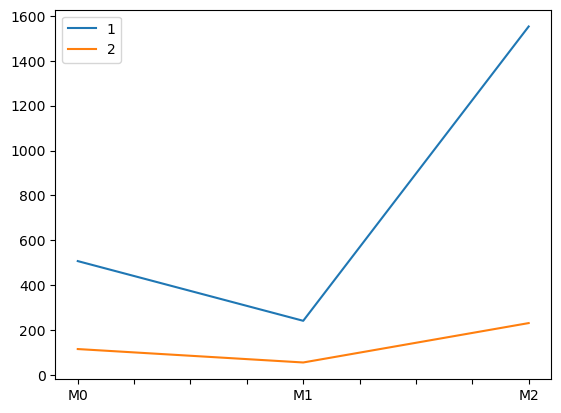

In [35]:
pd.concat([PP1,PP2], keys=[1,2], axis=1).plot()

In language modeling, perplexity is a measure of how well a probability model predicts a test set. It is often used to compare different models: the lower the perplexity, the better the model's performance in terms of predicting the test set. When dealing with n-gram models like unigrams, bigrams, and trigrams, the relationship between the value of 'n' and the perplexity of the model on a given test corpus can vary, depending on several factors.

1. **Data Sparsity**: As 'n' increases in n-gram models (moving from unigram to bigram to trigram), the models become more sensitive to the specific sequences of words in the training data. This can lead to an issue known as data sparsity: trigram models, for example, require a lot more data to encounter all possible word sequences of length three. If your training corpus isn't sufficiently large and diverse, trigram and higher n-gram models may suffer because they haven't seen enough examples of each word sequence during training. 

2. **Generalization vs. Specificity**: Unigram models, being the simplest, have high generalizability but low specificity—they treat each word independently and don't capture the context. Trigram models, on the other hand, capture more context but might become too specific to the training data, failing to generalize well to unseen data. If the test corpus contains many word sequences not seen in the training corpus, a higher n-gram model might perform poorly, leading to higher perplexity.

3. **Model Complexity and Overfitting**: Higher n-gram models (like trigrams) are more complex and can potentially overfit the training data. Overfitting occurs when a model learns patterns that are specific to the training data, including noise and outliers, rather than capturing the underlying structure of the language. This can lead to increased perplexity on the test set, as the model is less able to generalize to unseen data.

In summary, whether perplexity increases or decreases with n depends on the characteristics of your training and test data, as well as how well the model's complexity is suited to the amount and diversity of the data. In an ideal scenario with ample, diverse training data, you might expect a bigram or trigram model to outperform a unigram model, leading to lower perplexity. However, in practical scenarios, especially when dealing with limited or highly specific datasets, the relationship might not be so straightforward.

## Generate Text

We use so-called "stupid back-off" to account for missing ngrams.

### `generate_text()`

In [36]:
M[0].loc[['<s>','</s>']]

,n,p,i
w0,,,
<s>,12812,0.055601,4.168736
</s>,12812,0.055601,4.168736


In [37]:
M[2].loc[('</s>','<s>')]

,n,p,i,cp,ci
w2,,,,,
<s>,1,0.000004,17.813944,0.000078,13.645208
a,152,0.000660,10.566016,0.011864,6.397281
about,10,0.000043,14.492016,0.000781,10.323280
absence,1,0.000004,17.813944,0.000078,13.645208
absolutely,1,0.000004,17.813944,0.000078,13.645208
...,...,...,...,...,...
you,231,0.001002,9.962195,0.018030,5.793459
young,1,0.000004,17.813944,0.000078,13.645208
younger,2,0.000009,16.813944,0.000156,12.645208


In [38]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    words = ['</s>', '<s>']
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError:
            
            print("BACKOFF!")

            # Get the last word in the bigram
            ug = bg[1]
            next_word = M[1].loc[ug].sample(weights='cp').index[0]
                    
        words.append(next_word)
    
    text = ' '.join(words[2:])
    print(text.replace(' </s> <s> ', '.\n\n').upper()+".")

In [39]:
generate_text(M)

AND IN HIS ESTIMATION THE WOMAN HE MIGHT JOIN THEM.

IT HAD DONE NOTHING TO URGE THAT BECAUSE SHE BELIEVED MR.

JENNINGS MUCH MORE ABLE TO ASSIST IN THE FAMILY ONE WHO SO INJURED THE PEACE TURNED HIM ON VERY PARTICULAR KIND.

EACH LADY WAS AND MADE HER HARDLY AT ALL ON YOUR SIDE IN THE SAME TIME.

AND ANNE AFTER A SHORT PAUSE MR SHEPHERD S ASSURANCES OF HIS MOTHER HAD YET REACHED HIM HE SAID BUT NOT A BIT DID WALTER STIR.

COME COME THIS WON T DO.

YOU SEE HOW SHE HAD BEEN TWISTED IN HER RECEPTION OF HIM OBEYED THE FIRST.

SHE RESIGNED HERSELF TO HER COMPREHENSION TO MAKE HER HAPPIER.

NO I CANNOT HELP THINKING IN SHORT BY THE QUESTION A VERY FASHIONABLE LOOKING YOUNG WOMAN WHO HAS EVER PASSED TO THEIR LASTING APPROBATION.

MY DEAR TIS A SAD THING FOR SPORTSMEN TO LOSE HIM BEFORE SINCE HIS MARRIAGE HAD GIVEN EACH OF THE DIFFERENT TOOTHPICK CASES AT GRAY S IN MAKING A BOLD PUBLIC DECLARATION WHEN HE WAS QUITE OF THE PARTY.

AND IN THE MORNING.

A NOTE OF EXPLANATION.

BUT IT WAS COMPLET

## Save

In [40]:
path_prefix = f"{output_dir}/austen-combo"
NG.to_csv(f"{path_prefix}-NG.csv")
for i in range(len(M)):
    M[i].to_csv(f"{path_prefix}-M{i}.csv", index=True)